In [131]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [132]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
#fill NaN with mean
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

C:\Users\aaron\AppData\Local\Temp\ipykernel_122432\2107570315.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].mean(), inplace=True)


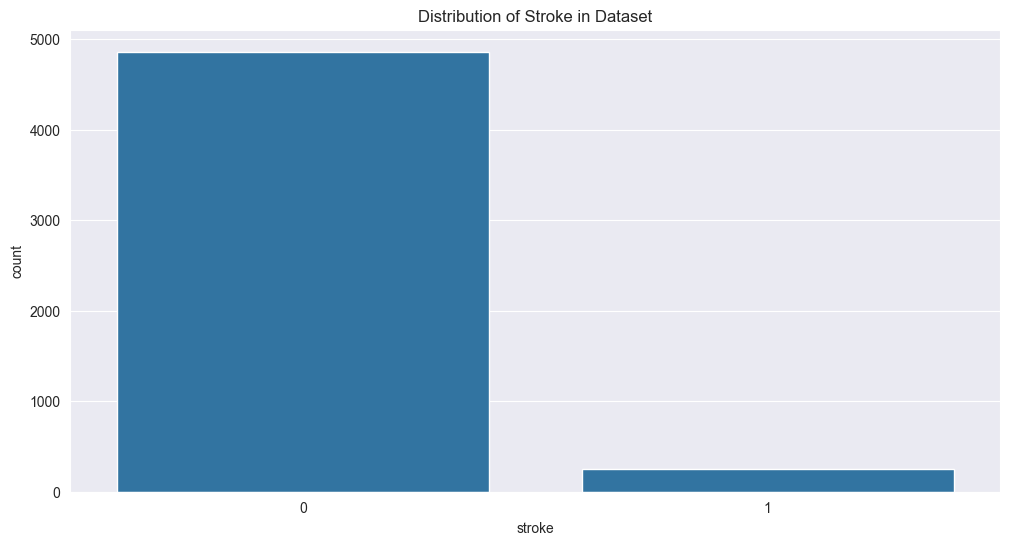

In [133]:
# data inbalance
plt.figure(figsize=(12, 6))
sns.countplot(x='stroke', data=data)
plt.title('Distribution of Stroke in Dataset')
plt.show()

Text(0.5, 1.0, 'Age Distribution')

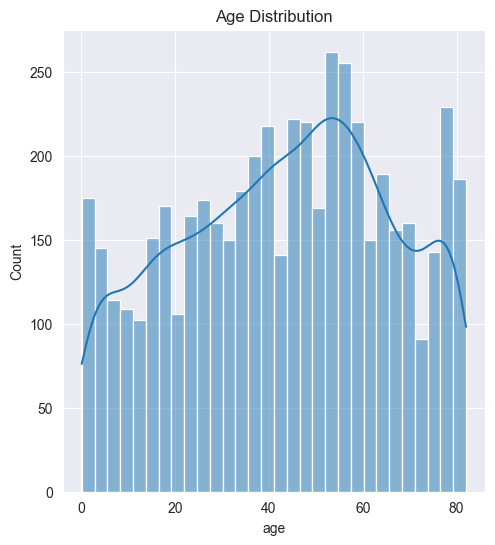

In [134]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['age'], bins=30, kde=True)
plt.title('Age Distribution')

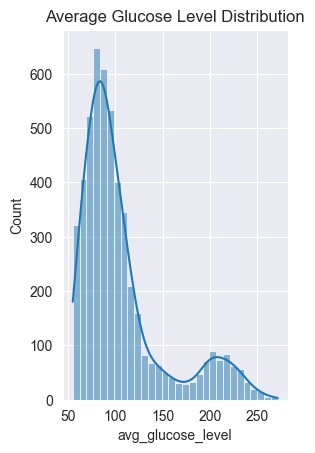

In [135]:
plt.subplot(1, 2, 2)
sns.histplot(data['avg_glucose_level'], bins=30, kde=True)
plt.title('Average Glucose Level Distribution')
plt.show()

In [136]:
encoder = LabelEncoder()
data['gender'] = encoder.fit_transform(data['gender'])
data['ever_married'] = encoder.fit_transform(data['ever_married'])
data['work_type'] = encoder.fit_transform(data['work_type'])
data['Residence_type'] = encoder.fit_transform(data['Residence_type'])
data['smoking_status'] = encoder.fit_transform(data['smoking_status'])

In [137]:
X = data.drop(['stroke', 'id'], axis=1).values
y = data['stroke'].values

# StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [138]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

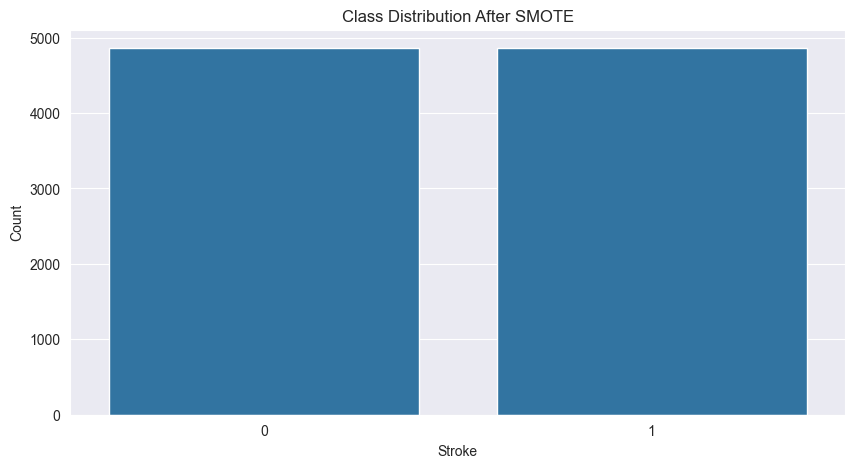

In [139]:
# resampling
plt.figure(figsize=(10, 5))
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

In [140]:
# splite data
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# convert tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)


In [141]:
# define model
class StrokePredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_units=32, dropout_rate=0.3):
        super(StrokePredictionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, hidden_units // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [142]:
def train_model(epochs=300):
    model = StrokePredictionModel(input_dim=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        y_train_true, y_train_pred = [], []
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct_train += ((outputs > 0.5).float() == targets).sum().item()
            total_train += targets.size(0)
            y_train_true.extend(targets.numpy())
            y_train_pred.extend((outputs > 0.5).float().numpy())

        train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train
        train_precision = precision_score(y_train_true, y_train_pred)
        train_recall = recall_score(y_train_true, y_train_pred)
        train_f1 = f1_score(y_train_true, y_train_pred)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        
        # eval
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        y_val_true, y_val_pred = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                correct_val += ((outputs > 0.5).float() == targets).sum().item()
                total_val += targets.size(0)
                y_val_true.extend(targets.numpy())
                y_val_pred.extend((outputs > 0.5).float().numpy())

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_precision = precision_score(y_val_true, y_val_pred)
        val_recall = recall_score(y_val_true, y_val_pred)
        val_f1 = f1_score(y_val_true, y_val_pred)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    return (model, y_val_true, y_val_pred, train_losses, val_losses, 
            train_accuracies, val_accuracies, train_precisions, val_precisions, 
            train_recalls, val_recalls, train_f1s, val_f1s)

In [143]:
# init model
metrics = train_model()
(model, y_val_true, y_val_pred, train_losses, val_losses, 
 train_accuracies, val_accuracies, train_precisions, val_precisions, 
 train_recalls, val_recalls, train_f1s, val_f1s) = metrics

Epoch [1/300] - Train Loss: 0.5932, Val Loss: 0.4817, Train Acc: 0.6902, Val Acc: 0.7841
Epoch [2/300] - Train Loss: 0.4778, Val Loss: 0.4531, Train Acc: 0.7802, Val Acc: 0.7892
Epoch [3/300] - Train Loss: 0.4604, Val Loss: 0.4440, Train Acc: 0.7932, Val Acc: 0.7949
Epoch [4/300] - Train Loss: 0.4499, Val Loss: 0.4362, Train Acc: 0.7984, Val Acc: 0.8005
Epoch [5/300] - Train Loss: 0.4435, Val Loss: 0.4314, Train Acc: 0.8022, Val Acc: 0.8021
Epoch [6/300] - Train Loss: 0.4364, Val Loss: 0.4262, Train Acc: 0.8069, Val Acc: 0.8123
Epoch [7/300] - Train Loss: 0.4345, Val Loss: 0.4239, Train Acc: 0.8070, Val Acc: 0.8118
Epoch [8/300] - Train Loss: 0.4352, Val Loss: 0.4222, Train Acc: 0.8093, Val Acc: 0.8113
Epoch [9/300] - Train Loss: 0.4322, Val Loss: 0.4191, Train Acc: 0.8120, Val Acc: 0.8129
Epoch [10/300] - Train Loss: 0.4301, Val Loss: 0.4167, Train Acc: 0.8146, Val Acc: 0.8175
Epoch [11/300] - Train Loss: 0.4245, Val Loss: 0.4141, Train Acc: 0.8139, Val Acc: 0.8180
Epoch [12/300] - Tr

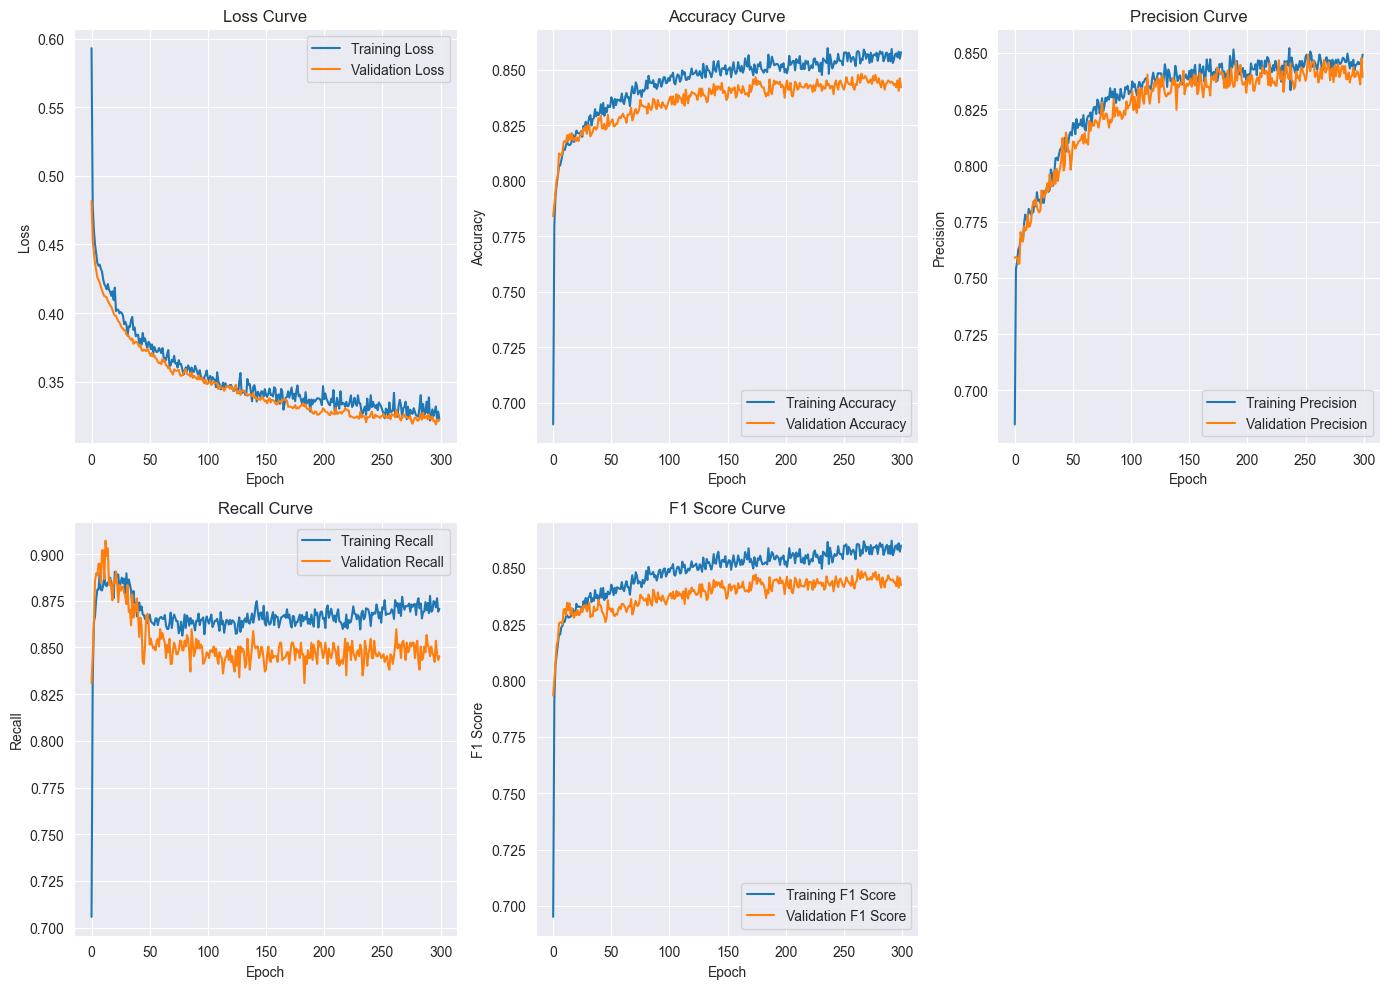

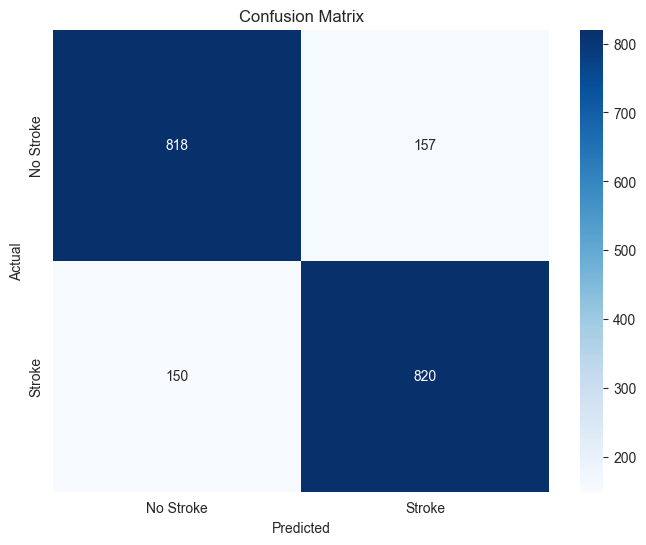

In [144]:
# plot metrics
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()


plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()


plt.subplot(2, 3, 3)
plt.plot(train_precisions, label='Training Precision')
plt.plot(val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()


plt.subplot(2, 3, 4)
plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()


plt.subplot(2, 3, 5)
plt.plot(train_f1s, label='Training F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()


plt.tight_layout()
plt.show()

# confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()